In [2]:
import cv2
from mpl_toolkits.mplot3d import Axes3D
import logging
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D
from math import pow , sqrt, atan2
import math
import pywt
from scipy.signal import find_peaks

from sklearn.manifold import LocallyLinearEmbedding
from sklearn import manifold, datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(color_codes=True)

from scipy.signal import argrelextrema
from scipy.spatial.distance import pdist
from scipy.stats.mstats import pearsonr, spearmanr



Axes3D


mpl_toolkits.mplot3d.axes3d.Axes3D

source: 
hessian :https://link.springer.com/chapter/10.1007/978-3-642-27497-8_13

# Functions

In [363]:
# Calculate the Residual variance with original dataset and LLE or HLLE dataset

def res_var(X_origi, X_transfo):
    #X_origi   = original dataset
    #X_transfo = modified dataset
    
    #pairwise euclidean distance
    Dx = pdist(X_origi, 'euclidean')
    Dy = pdist(X_transfo, 'euclidean')

    #Pearson correlation
    pxy, _ = pearsonr(Dx, Dy)

    #residual variance
    res_var = 1 - pxy**2
    
    return res_var
# Calculate the Spearman's rho coeff with original dataset and LLE or HLLE dataset
def SpearsmansRho (X_origi, X_transfo):
    #X_origi   = original dataset
    #X_transfo = modified dataset
    
    nbrs = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(X_origi)
    dist, _ = nbrs.kneighbors(X_origi)

    nbrs2 = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(X_transfo)
    dist2, _ = nbrs2.kneighbors(X_transfo)

    dist  = np.delete(dist, 0, 1)
    dist2 = np.delete(dist2, 0, 1)
    coef, p = spearmanr(dist, dist2,axis=None)
    return  np.mean(coef)

# find best number of neighbor in function of the Topology
def num_neigh_SP(Data,dim, meth,plot="ON"):
    SP_Rho_vect       = []
    Residual_var_vect = []
    N_Neigh_Max       = 35
    NCOMP             = dim
    if meth == "standard":
        nmin   = NCOMP+1
        Vect_N = np.arange(nmin,N_Neigh_Max,1)
    if meth == "hessian":
        nmin   = round(NCOMP*(NCOMP+3)/2)+2
        Vect_N = np.arange( nmin,N_Neigh_Max,1)
    Tot_Err     = []
    for j in range(nmin):
        SP_Rho_vect.append(0)
        Residual_var_vect.append(0)
    for i in Vect_N:
        DataTransfo, err = manifold.locally_linear_embedding(Data, n_neighbors=i,n_components=NCOMP,method = meth,eigen_solver="dense")
        Tot_Err.append(err)
        SP_Rho_vect.append(SpearsmansRho(Data,DataTransfo))
        Residual_var_vect.append(res_var(Data,DataTransfo))

    Tot_err = np.array(Tot_Err)
    maxval_SP =max(SP_Rho_vect[nmin:]) 
    indicemax_SP = SP_Rho_vect.index(maxval_SP)
    minval_SP =min(SP_Rho_vect[nmin:]) 
    indicemin_SP = SP_Rho_vect.index(minval_SP)
    
    
    if plot == "ON":
        plt.figure(meth,figsize=(8, 8))
        plt.title( meth)
        plt.xlabel("Number of Neighbor")
        plt.ylabel("Values")
        plt.plot (SP_Rho_vect,color ="red",label="Spearman's Rho")
        plt.plot (Residual_var_vect,color ="yellow",label="residual variance")
        #plt.plot(combin,color ="orange",label="Spearman's Rho* residual variance")

        plt.plot (indicemax_SP,maxval_SP,"go",color ="green",label="max Spearman's Rho")
        plt.plot (indicemin_SP,minval_SP,"go",color ="red",label="min Spearman's Rho")

        plt.legend(loc ="lower left")
        plt.text(20,0,"worst K = "+ str(indicemin_SP) +" and best K = " + str(indicemax_SP))
        
    return indicemax_SP,indicemin_SP,SP_Rho_vect,Residual_var_vect

# find best number of neighbor in function of the classification and topology
def num_neigh(Data,Label,dim, meth,Kmx,plot="ON"):
    SP_Rho_vect       = []
    Residual_var_vect = []
    classif_vect      = []
    N_Neigh_Max       = 35
    NCOMP             = 2


    # We split the data into train and test to evaluate the classification 
    Split = 0.3
    X_tr, X_ts, Label_tr, Label_ts = train_test_split(Data, Label, test_size=Split)

    # Here we normalize the data (Not neceesary on our case because data is black and white pixel)
    X_tr_St     = StandardScaler().fit_transform(X_tr)
    X_ts_St     = StandardScaler().fit_transform(X_ts)
    X_tr_Norm   = Normalizer().fit_transform(X_tr_St)
    X_ts_Norm   = Normalizer().fit_transform(X_ts_St)

    if meth == "standard":
        nmin   = NCOMP+1
        Vect_N = np.arange(nmin,N_Neigh_Max,1)
    if meth == "hessian":
        nmin   = round(NCOMP*(NCOMP+3)/2)+2
        Vect_N = np.arange( nmin,N_Neigh_Max,1)
    Tot_Err     = []
    for j in range(nmin):
        SP_Rho_vect.append(0)
        Residual_var_vect.append(0)
        classif_vect.append(0)

    for i in Vect_N:
        clf = manifold.LocallyLinearEmbedding(n_neighbors=i,n_components=NCOMP,method = meth,eigen_solver="dense")
        X_tr_transfo  = clf.fit_transform(X_tr_Norm)
        X_ts_transfo  = clf.transform(X_ts_Norm)
        kopt_transfo = knn(X_tr_transfo,X_ts_transfo,Label_tr,Label_ts, Kmx)
        classif_vect.append(classifR(X_tr_Norm,X_ts_Norm,X_tr_transfo,X_ts_transfo,Label_tr,Label_ts,kopt_transfo))
        SP_Rho_vect.append(SpearsmansRho(X_tr_transfo,X_tr_Norm))
        Residual_var_vect.append(res_var(X_tr_transfo,X_tr_Norm))


    maxval_C    = max(classif_vect[nmin:]) 
    indicemax_C = WorstNN_C = classif_vect.index(maxval_C)
    minval_C    = min(classif_vect[nmin:]) 
    indicemax_C = BestNN_C = classif_vect.index(minval_C)
    
    maxval_SP    = max(SP_Rho_vect[nmin:]) 
    indicemax_SP = BestNN_SP = SP_Rho_vect.index(maxval_SP)
    minval_SP    = min(SP_Rho_vect[nmin:]) 
    indicemin_SP = WorstNN_SP = SP_Rho_vect.index(minval_SP)


    if plot == "ON":
        plt.figure(meth,figsize=(8, 8))
        plt.title( meth)
        plt.xlabel("Number of Neighbor")
        plt.ylabel("Values")
        plt.plot (SP_Rho_vect,color ="blue",label="Spearman's Rho")
        plt.plot (Residual_var_vect,color ="green",label="residual variance")
        plt.plot(classif_vect,color ="orange",label="Classification rate")

        plt.plot (indicemax_C,maxval_C,"go",color ="yellow",label="max Classification rate")
        plt.plot (indicemin_C,minval_C,"go",color ="red",label="min Classification rate")

        plt.plot (indicemax_SP,maxval_SP,"go",color ="black",label="max Spearman")
        plt.plot (indicemin_SP,minval_SP,"go",color ="grey",label="min Spearman")
        
        plt.legend(loc ="lower left")
        print("worst K topo = "+ str(WorstNN_SP) +" and best K topo = " + str(BestNN_SP))
        print("worst K class = "+ str(WorstNN_C) +" and best K class = " + str(BestNN_C))

    return BestNN_SP,WorstNN_SP,BestNN_C,WorstNN_C
# find best number of neighbor in function of the classification and topology 

def num_neigh_RD(X_tr, X_ts, Label_tr, Label_ts,dim, meth,Kmx,plot="ON"):
    SP_Rho_vect       = []
    Residual_var_vect = []
    classif_vect      = []
    N_Neigh_Max       = 70
    NCOMP             = dim


    # Here we normalize the data (Not neceesary on our case because data is black and white pixel)
    X_tr_St     = StandardScaler().fit_transform(X_tr)
    X_ts_St     = StandardScaler().fit_transform(X_ts)
    X_tr_Norm   = Normalizer().fit_transform(X_tr_St)
    X_ts_Norm   = Normalizer().fit_transform(X_ts_St)

    if meth == "standard":
        nmin   = NCOMP+1
        Vect_N = np.arange(nmin,N_Neigh_Max,1)
    if meth == "hessian":
        nmin   = round(NCOMP*(NCOMP+3)/2)+2
        Vect_N = np.arange( nmin,N_Neigh_Max,1)
    Tot_Err     = []
    for j in range(nmin):
        SP_Rho_vect.append(0)
        Residual_var_vect.append(0)
        classif_vect.append(0)

    for i in Vect_N:
        clf = manifold.LocallyLinearEmbedding(n_neighbors=i,n_components=NCOMP,method = meth,eigen_solver="dense")
        X_tr_transfo  = clf.fit_transform(X_tr_Norm)
        X_ts_transfo  = clf.transform(X_ts_Norm)
        kopt_transfo = knn(X_tr_transfo,X_ts_transfo,Label_tr,Label_ts, Kmx)
        classif_vect.append(classifR(X_tr_Norm,X_ts_Norm,X_tr_transfo,X_ts_transfo,Label_tr,Label_ts,kopt_transfo))
        SP_Rho_vect.append(SpearsmansRho(X_tr_transfo,X_tr_Norm))
        Residual_var_vect.append(res_var(X_tr_transfo,X_tr_Norm))


    maxval_C    = max(classif_vect[nmin:]) 
    indicemax_C = WorstNN_C = classif_vect.index(maxval_C)
    minval_C    = min(classif_vect[nmin:]) 
    indicemin_C = BestNN_C = classif_vect.index(minval_C)
    
    maxval_SP    = max(SP_Rho_vect[nmin:]) 
    indicemax_SP = BestNN_SP = SP_Rho_vect.index(maxval_SP)
    minval_SP    = min(SP_Rho_vect[nmin:]) 
    indicemin_SP = WorstNN_SP = SP_Rho_vect.index(minval_SP)


    if plot == "ON":
        plt.figure(meth,figsize=(8, 8))
        plt.title( meth)
        plt.xlabel("Number of Neighbor")
        plt.ylabel("Values")
        plt.plot (SP_Rho_vect,color ="blue",label="Spearman's Rho")
        plt.plot (Residual_var_vect,color ="green",label="residual variance")
        plt.plot(classif_vect,color ="orange",label="Classification rate")

        plt.plot (indicemax_C,maxval_C,"go",color ="yellow",label="max Classification rate")
        plt.plot (indicemin_C,minval_C,"go",color ="red",label="min Classification rate")

        plt.plot (indicemax_SP,maxval_SP,"go",color ="black",label="max Spearman")
        plt.plot (indicemin_SP,minval_SP,"go",color ="grey",label="min Spearman")
        
        plt.legend(loc ="lower left")
        print("worst K topo = "+ str(WorstNN_SP) +" and best K topo = " + str(BestNN_SP))
        print("worst K class = "+ str(WorstNN_C) +" and best K class = " + str(BestNN_C))

    return BestNN_SP,WorstNN_SP,BestNN_C,WorstNN_C

# criterion for the dimensionality reduction : Classification Rate
def classifR(Data_original_train,Data_original_test,Data_transfo_train,Data_transfo_test,lab_train,lab_test,K):
   
    #Create KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=K)
    
    #Train the model using the training sets
    knn.fit(Data_original_train,np.array(lab_train).ravel())

    #Predict the response for test dataset
    y_pred = knn.predict(Data_original_test)

    Acc_original = metrics.accuracy_score(lab_test, y_pred)
    
    #Train the model using the training sets
    knn.fit(Data_transfo_train,    np.array(lab_train).ravel())

    #Predict the response for test dataset
    y_pred = knn.predict(Data_transfo_test)

    Acc_transfo = metrics.accuracy_score(lab_test, y_pred)
    
    ClassR = (Acc_original -Acc_transfo)/Acc_original
    
    return ClassR

# find best knn neigbor
def knn(Data_train,Data_test,Data_train_label,Data_test_label, Kmax):
    Vect_K      = np.arange(1,Kmax,1)
    Accs =[]
    for i in Vect_K:
        #Create KNN Classifier
        knn = KNeighborsClassifier(n_neighbors=i)
        
        #Train the model using the training sets
        knn.fit(Data_train,  np.array(Data_train_label).ravel())

        #Predict the response for test dataset
        y_pred = knn.predict(Data_test)
    
        Accs.append(metrics.accuracy_score(Data_test_label, y_pred))
    Kopt = Vect_K[Accs.index(max(Accs))]
    return Kopt

# find best ypred
def BestPredictKNN(Data_train,Data_test,Data_train_label,Data_test_label, Kmax):
    Vect_K      = np.arange(1,Kmax,1)
    Accs =[]
    for i in Vect_K:
        #Create KNN Classifier
        knn = KNeighborsClassifier(n_neighbors=i)
        
        #Train the model using the training sets
        knn.fit(Data_train,  np.array(Data_train_label).ravel())

        #Predict the response for test dataset
        y_pred = knn.predict(Data_test)
    
        Accs.append(metrics.accuracy_score(Data_test_label, y_pred))
    Kopt = Vect_K[Accs.index(max(Accs))]
    #Create KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=Kopt)

    #Train the model using the training sets
    knn.fit(Data_train,  np.array(Data_train_label).ravel())

    #Predict the response for test dataset
    y_pred = knn.predict(Data_test)
    Fone = metrics.f1_score(Data_test_label, y_pred,average=None)

    return y_pred,max(Accs),Fone
        

# TOY's Data set


In this section we will play with a swiss roll data set to understand the characteristic of LLE and HLLE.

we want to study the following point:

1) The effect of the number of datapoint


2) The effect of the best number of neighbor depending of 

       a) the topology
       
       b)the classification rate

3) The effect of the noise



## 1) The effect of the number of datapoint

Here we will implement, the HLLE and LLE with different of number of data points. We want to have a visuable analsysis. Thus we choose Dim =2 and the Spearman's rho to maximize the topology preservation.


In [298]:
# NORUN it takes more than 1 hour..

# compute the best number of neigbor and the projection with different initial data points for LLE and HLLE
# and make a mean with 10 values


Vect_point = [100,500,1000,1500,2000]

MaxLLE_Vect             = []
MaxHLLE_Vect            = []
Dataset_swissroll_point = []
HLLE_VECT               = []
LLE_VECT                = [] 

color_Vect              = []

err_Vect_LLE            = []
err_Vect_HLLE           = []

Spearman_vectS_LLE      = []
Spearman_vectS_HLLE     = []

Nmean = 10

for i in Vect_point:
    Dataset, color= datasets.make_swiss_roll(n_samples=i,noise = 0.0)
    color_Vect.append(color)
    Dataset_swissroll_point.append(Dataset)
    
    Spearman_vectS_LLE_mean  = []
    Spearman_vectS_HLLE_mean = []
    _,_,SpLLE,RvLLE = num_neigh_SP(Dataset,2, "standard","OFF")
    _,_,SpHLLE,RvHLLE= num_neigh_SP(Dataset,2, "hessian","OFF")
    #Make a mean
    Spearman_vectS_LLE_mean  = np.array(SpLLE)
    Spearman_vectS_HLLE_mean = np.array(SpHLLE)
    for j in range(Nmean-1):
        _,_,SpLLE,RvLLE = num_neigh_SP(Dataset,2, "standard","OFF")
        _,_,SpHLLE,RvHLLE= num_neigh_SP(Dataset,2, "hessian","OFF")
        Spearman_vectS_LLE_mean =Spearman_vectS_LLE_mean+np.array(SpLLE)
        Spearman_vectS_HLLE_mean =Spearman_vectS_HLLE_mean+np.array(SpHLLE)
    
    Spearman_vectS_HLLE_mean = Spearman_vectS_HLLE_mean/Nmean
    Spearman_vectS_LLE_mean  = Spearman_vectS_LLE_mean/Nmean
    
    maxval_SP_LLE = max(Spearman_vectS_LLE_mean[nmin:]) 
    nmaxlle = np.where(Spearman_vectS_LLE_mean==maxval_SP_LLE)
    nmaxlle = nmaxlle[0][0]
    
    maxval_SP_HLLE = max(Spearman_vectS_HLLE_mean[nmin:]) 
    nmaxhlle = np.where(Spearman_vectS_HLLE_mean ==maxval_SP_HLLE)
    nmaxhlle = nmaxhlle[0][0]


    MaxLLE_Vect.append(nmaxlle)
    MaxHLLE_Vect.append(nmaxhlle)
    Spearman_vectS_LLE.append(Spearman_vectS_LLE_mean)
    Spearman_vectS_HLLE.append(Spearman_vectS_HLLE_mean)
    XHLLE, errHLLE = manifold.locally_linear_embedding(Dataset, n_neighbors=nmaxhlle,n_components=2,method = "hessian", eigen_solver='dense')
    XLLE, errLLE = manifold.locally_linear_embedding(Dataset, n_neighbors=nmaxlle,n_components=2,method = "standard", eigen_solver='dense')
    HLLE_VECT.append(XHLLE)
    LLE_VECT.append(XLLE)
    err_Vect_LLE.append(errLLE)
    err_Vect_HLLE.append(errHLLE)
    print("done for " + str(i))
        



done for 100
done for 500
done for 1000
done for 1500
done for 2000


In [325]:
# compute the best number of neigbor and the projection with different initial data points for LLE and HLLE

Vect_point = [100,500,1000,1500,2000]

#initialization
MaxLLE_Vect             = []
MaxHLLE_Vect            = []
Dataset_swissroll_point = []
HLLE_VECT               = []
LLE_VECT                = [] 
color_Vect              = []
err_Vect_LLE            = []
err_Vect_HLLE           = []
Spearman_vectS_LLE      = []
Spearman_vectS_HLLE     = []

for i in Vect_point:
    Dataset, color = datasets.make_swiss_roll(n_samples=i,noise = 0.0)
    data_St        = StandardScaler().fit_transform(Dataset)
    dataset        = Normalizer().fit_transform(data_St)
    color_Vect.append(color)
    Dataset_swissroll_point.append(Dataset)
    
    
    nmaxlle,_,SpLLE,RvLLE    = num_neigh_SP(Dataset,2, "standard","OFF")
    nmaxhlle,_,SpHLLE,RvHLLE = num_neigh_SP(Dataset,2, "hessian","OFF")
    MaxLLE_Vect.append(nmaxlle)
    MaxHLLE_Vect.append(nmaxhlle)
    Spearman_vectS_LLE.append(SpLLE)
    Spearman_vectS_HLLE.append(SpHLLE)
    
    XLLE, errLLE   = manifold.locally_linear_embedding(Dataset, n_neighbors=nmaxlle,n_components=2,method = "standard", eigen_solver='dense')
    XHLLE, errHLLE = manifold.locally_linear_embedding(Dataset, n_neighbors=nmaxhlle,n_components=2,method = "hessian", eigen_solver='dense')
    HLLE_VECT.append(XHLLE)
    LLE_VECT.append(XLLE)
    err_Vect_LLE.append(errLLE)
    err_Vect_HLLE.append(errHLLE)
    print("done for " + str(i))

 

done for 100
done for 500
done for 1000
done for 1500
done for 2000


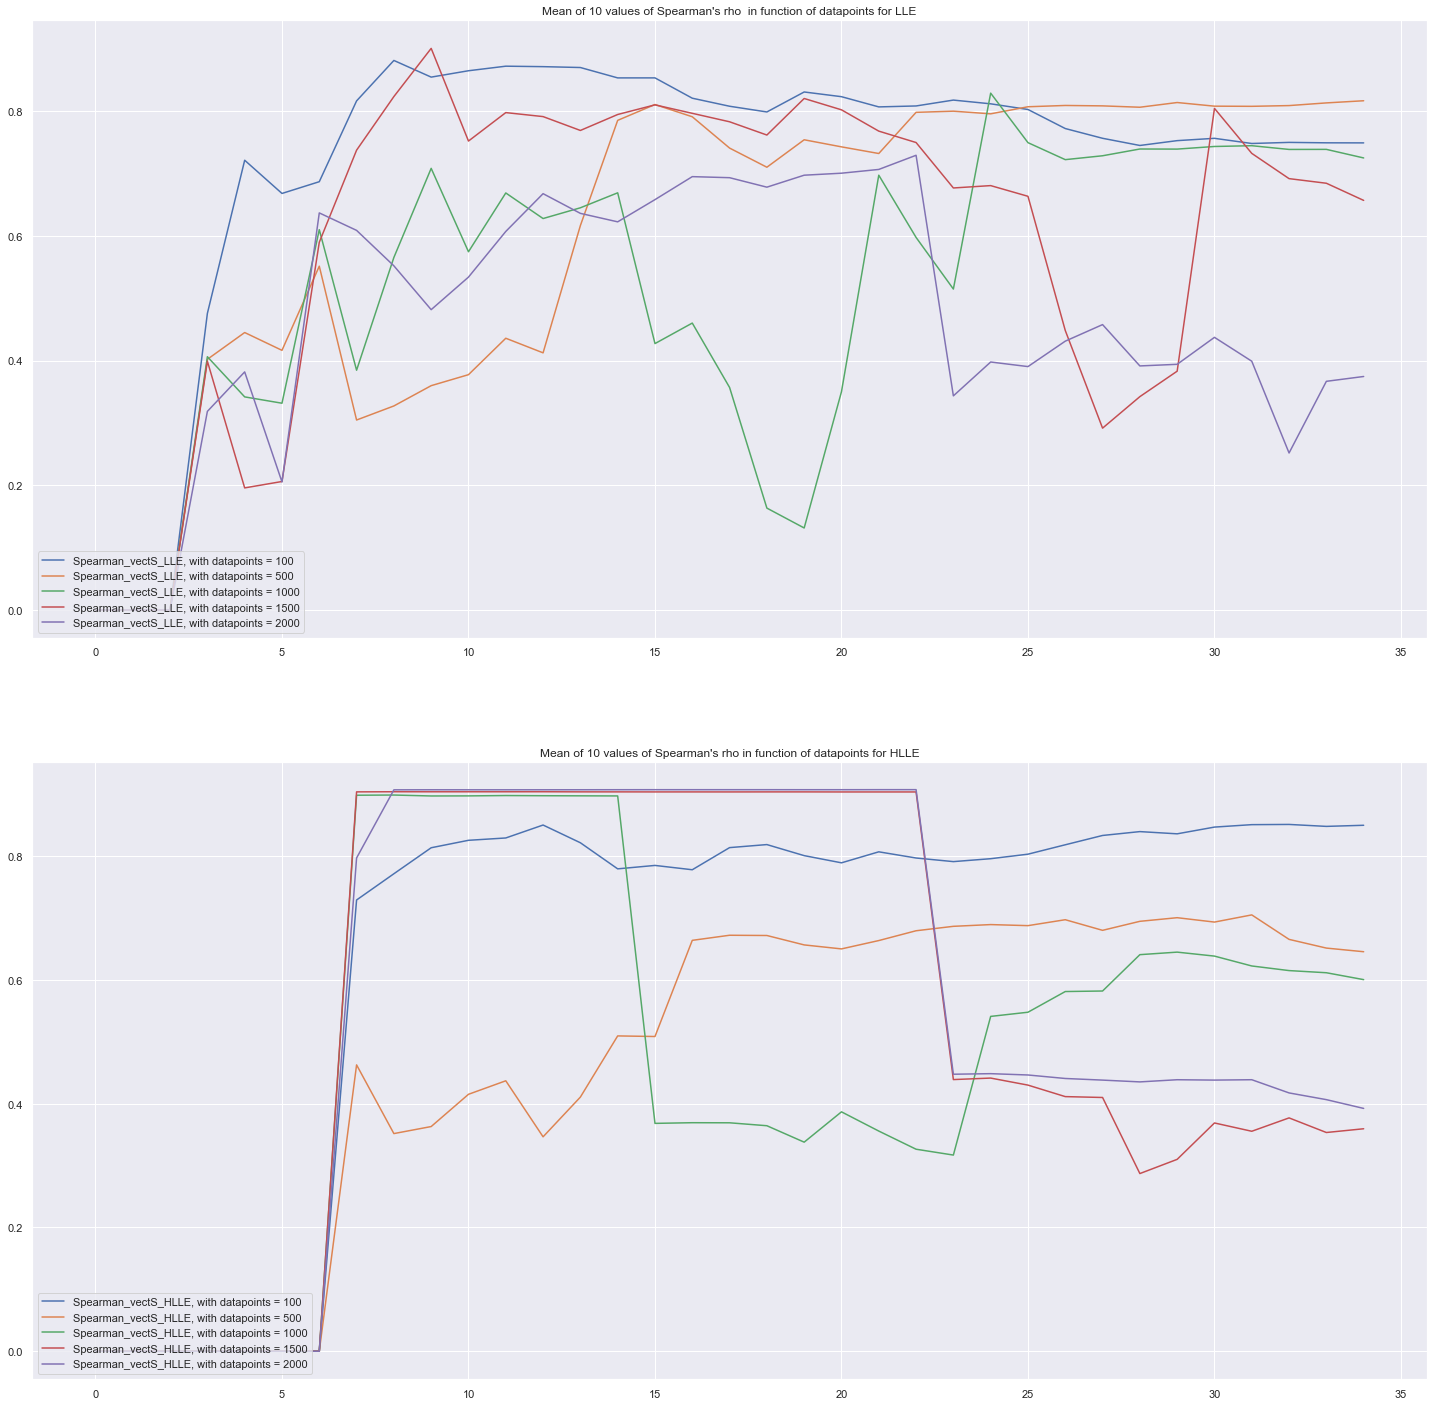

In [341]:
# plot the spearamns'rho in function of number of datapoints and the number of neighbor in fct of Datapoint

fig = plt.figure(figsize=(25, 25))
ax1 = fig.add_subplot(211)
"""ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)

ax5 = fig.add_subplot(223)
ax6 = fig.add_subplot(224)
"""
j = 0

for i in Vect_point:
    ax1.plot (Spearman_vectS_LLE[j],label="Spearman_vectS_LLE, with datapoints = "+ str(i))
    j =j+1
ax1.legend(loc ="lower left")
plt.title("Mean of 10 values of Spearman's rho  in function of datapoints for LLE")
j = 0
ax2 = fig.add_subplot(212)

for i in Vect_point:
    ax2.plot (Spearman_vectS_HLLE[j],label="Spearman_vectS_HLLE, with datapoints = "+ str(i))
    j =j+1
ax2.legend(loc ="lower left")
plt.title("Mean of 10 values of Spearman's rho in function of datapoints for HLLE")

"""ax3.plot (Vect_point,err_Vect_LLE,label="Reconstruction Error in function of datapoint for LLE")
plt.title("Reconstruction Error in function of datapoint for LLE")

ax4.plot (Vect_point,err_Vect_HLLE,label="Reconstruction Error in function of datapoint for HLLE")
plt.title("Reconstruction Error in function of datapoint for HLLE")

ax5.bar (Vect_point,MaxLLE_Vect,label="Best number of neighbor in function of datapoint for LLE")
plt.title("Best number of neighbor in function of datapoint for LLE")
ax6.plot (Vect_point,MaxHLLE_Vect,label="Best number of neighbor in function of datapoint for HLLE")
plt.title("Best number of neighbor in function of datapoint for HLLE")

"""

"""ax3.legend(loc ="upper right")
ax4.legend(loc ="upper right")

ax5.legend(loc ="upper right")
ax6.legend(loc ="upper right")
"""
plt.savefig("SpearmansDatapoints.png")


Description fig : 
The two first line of plot shows the coefficiant spearman's rho in function of the number of neighbor with different initial datapoints. The second lines shows the number of neighbor in function of the initial datapoints. The values showing are a mean of 10 random generation. There is a general  tendancy that more datapoint we have more number of neighbor we need.

Best projection LLE and HLLE for different size of data points


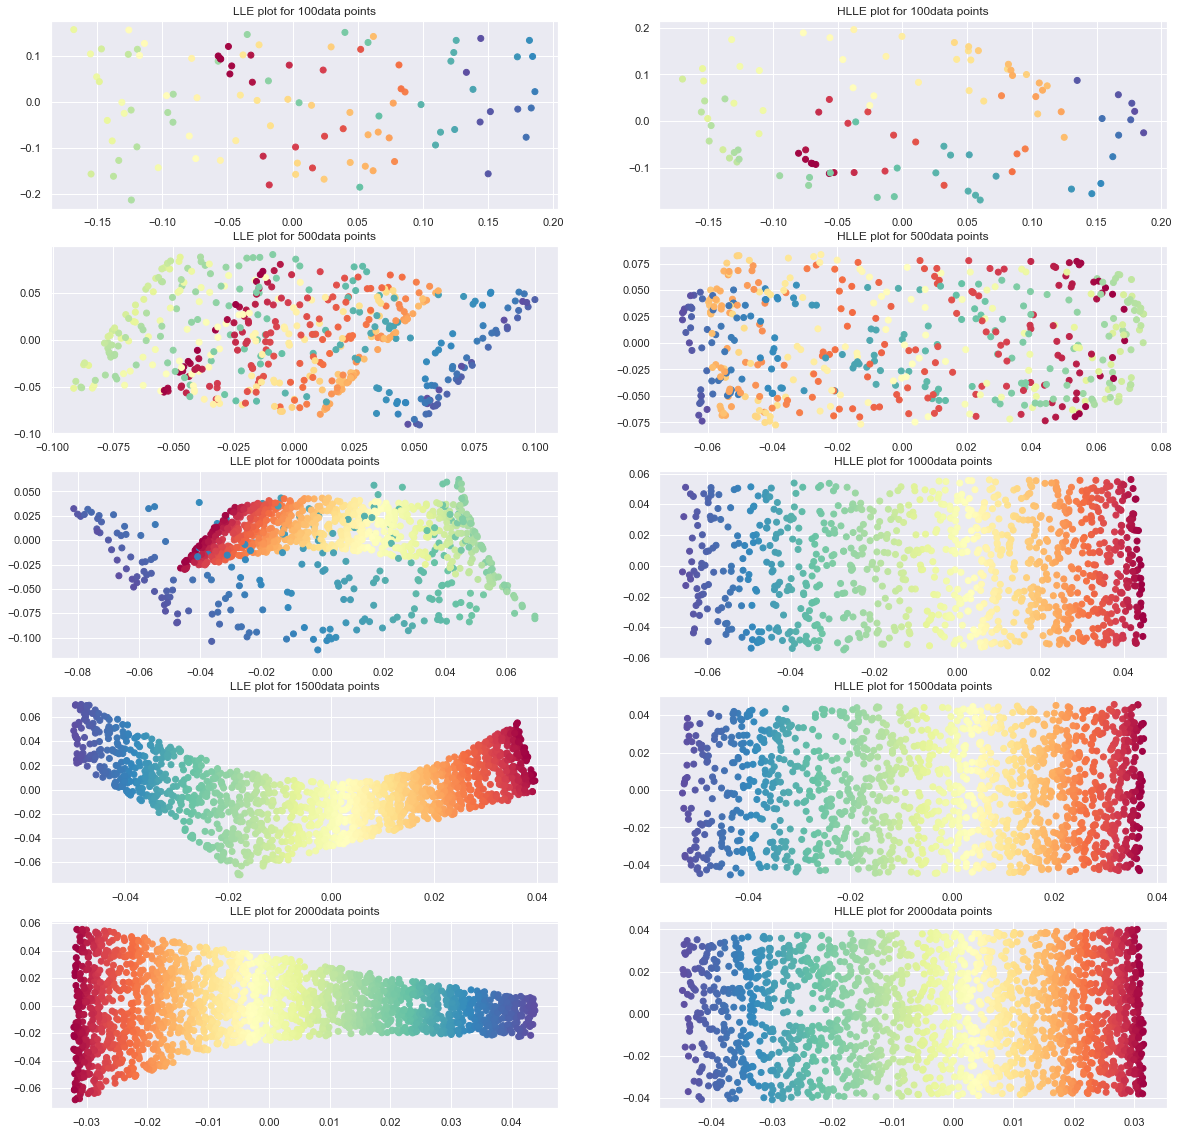

In [343]:
print("Best projection LLE and HLLE for different size of data points")
j = 0
fig = plt.figure(figsize=(20, 20))
for i in Vect_point:
    name = "LLE plot for "+ str(i)+ "data points"
    numLLE = int(1+(j)*2)
    ax = fig.add_subplot(5,2,numLLE)
    ax.scatter(LLE_VECT[j][:, 0], LLE_VECT[j][:, 1], c=color_Vect[j], cmap=plt.cm.Spectral)
    #plt.axis('tight')
    #plt.xticks([]), plt.yticks([])
    plt.title(name)
    numHLLE = int(2 +(j)*2)

    name = "HLLE plot for "+ str(i)+ "data points"
    ax = fig.add_subplot(5,2,numHLLE)
    ax.scatter(HLLE_VECT[j][:, 0], HLLE_VECT[j][:, 1], c=color_Vect[j], cmap=plt.cm.Spectral)
    #plt.axis('tight')
    #plt.xticks([]), plt.yticks([])
    plt.title(name)
    j = j+1
    
plt.savefig("ProjectionDatapoints.png")


description fig
This plot show the LLE (left) and HLLE (right) reconstruction in 2d for 5 differents number of datapoints (100,500,1000,1500,2500).
We can remark that we have a nice representation if the number of datapoints is bigger than ... for LLE and bigiger than ... for HLLE



Results: 
The plot of the spearmans's rho and the plot of the best number of neighbor we can see that more data we have, more neigbors we need. This results shows that the algorithme LLE and HLLE need a sufficient density to works well. 
Furthermore, when we plot in 2d the results of LLE and HLLE, we can remark that the representation seems well done only of we have sufficient point ( bigger than 1500 points). 
Finally, we can add that Hessian LLE is less affect by this constraint of number of data points.

With These graph we see that we need a minimum of data point equal to 1500 to make LLE and HLL working well.
Thus, We will use this number for the emd of the toy data analysis.

## 2) Best number of neighbor

In this section we will use the function num neigh  that comput the best and the worst Nneigh in function of the topology and classification.

To preserve the topology we use spearmans'rho and we confirm the result with the ressdual variance. The max value of the spearmans rho iis the best Nn and the minmum value is the worst Nn.

To have the best classification, we use the classification rate. The max values of the classification rate is the best Nn and the min is the worst Nn.

In the function num_neigh we split the data into test train with a split rati = 0.3. In the previous section we say that we need more than 1500 datapoints to have a functionnal algorithm thus we will use Datapoints_final >  1500 *1.45  Datapoints_final = 2200 to have the correct among of datapoints.

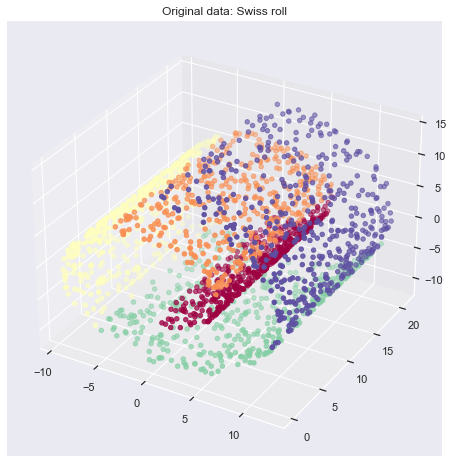

In [301]:
# the swiss roll
Number_datapoints = 2200
Dataset_swissroll, color = datasets.make_swiss_roll(n_samples=Number_datapoints,noise = 0.0)

data_St            = StandardScaler().fit_transform(Dataset_swissroll)
Dataset_swissroll  = Normalizer().fit_transform(data_St)

color_five = []
si = np.size(color)
vect = np.linspace(min(color),max(color),num = 6,endpoint = True,retstep = False, dtype = None)
for i in range(si):
    if color[i] <= vect[1]:
        color_five.append(0)
    if color[i] > vect[1] and color[i] <= vect[2]:
        color_five.append(1)
    if color[i] > vect[2] and color[i] <= vect[3]:
        color_five.append(2)
    if color[i] > vect[3] and color[i] <= vect[4]:
        color_five.append(3)
    if color[i] > vect[4]:
        color_five.append(4)
        
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(Dataset_swissroll[:, 0], Dataset_swissroll[:, 1], Dataset_swissroll[:, 2], c=color_five, cmap=plt.cm.Spectral)
ax.set_title("Original data: Swiss roll")
plt.savefig("OriginalData.png")


worst K topo = 16 and best K topo = 13
worst K class = 33 and best K class = 8
worst K topo = 16 and best K topo = 13
worst K class = 33 and best K class = 8


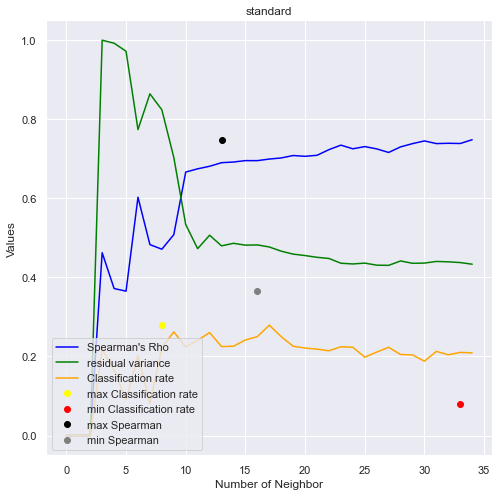

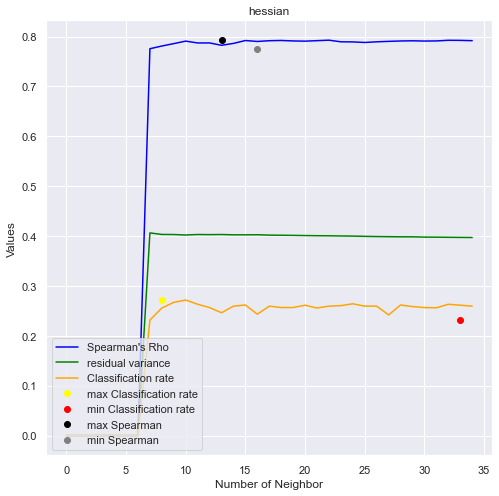

In [310]:
#run LLE and HLLE with different K
Best_Spear_N_LLE,Worst_Spear_N_LLE,Best_class_N_LLE,Worst_class_N_LLE = num_neigh(Dataset_swissroll,color_five,2, "standard",50,plot="ON")
Best_Spear_N_HLLE,Worst_Spear_N_HLLE,Best_class_N_HLLE,Worst_class_N_HLLE = num_neigh(Dataset_swissroll,color_five,2, "hessian",50,plot="ON")


worst K topo = 4 and best K topo = 33
worst K class = 7 and best K class = 12


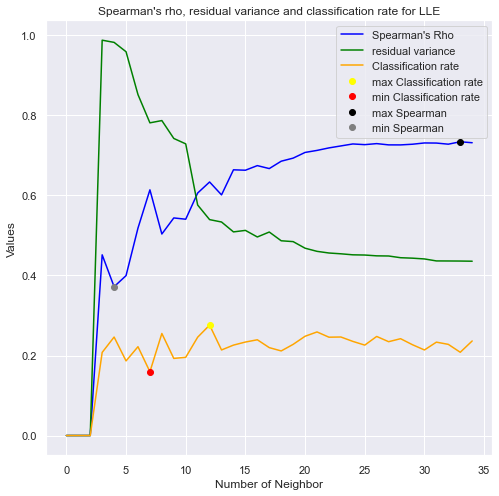

In [43]:
#we use this cell to save the plot in the function

Data =Dataset_swissroll
Label=color_five
dim= 2
meth="standard"
Kmx=50
plot="ON"

SP_Rho_vect       = []
Residual_var_vect = []
classif_vect      = []
N_Neigh_Max       = 35
NCOMP             = 2


# We split the data into train and test to evaluate the classification 
Split = 0.3
X_tr, X_ts, Label_tr, Label_ts = train_test_split(Data, Label, test_size=Split)

# Here we normalize the data (Not neceesary on our case because data is black and white pixel)
X_tr_St     = StandardScaler().fit_transform(X_tr)
X_ts_St     = StandardScaler().fit_transform(X_ts)
X_tr_Norm   = Normalizer().fit_transform(X_tr_St)
X_ts_Norm   = Normalizer().fit_transform(X_ts_St)

if meth == "standard":
    nmin   = NCOMP+1
    Vect_N = np.arange(nmin,N_Neigh_Max,1)
if meth == "hessian":
    nmin   = round(NCOMP*(NCOMP+3)/2)+2
    Vect_N = np.arange( nmin,N_Neigh_Max,1)
Tot_Err     = []
for j in range(nmin):
    SP_Rho_vect.append(0)
    Residual_var_vect.append(0)
    classif_vect.append(0)

for i in Vect_N:
    clf = manifold.LocallyLinearEmbedding(n_neighbors=i,n_components=NCOMP,method = meth,eigen_solver="dense")
    X_tr_transfo  = clf.fit_transform(X_tr_Norm)
    X_ts_transfo  = clf.transform(X_ts_Norm)
    kopt_transfo = knn(X_tr_transfo,X_ts_transfo,Label_tr,Label_ts, Kmx)
    classif_vect.append(classifR(X_tr_Norm,X_ts_Norm,X_tr_transfo,X_ts_transfo,Label_tr,Label_ts,kopt_transfo))
    SP_Rho_vect.append(SpearsmansRho(X_tr_transfo,X_tr_Norm))
    Residual_var_vect.append(res_var(X_tr_transfo,X_tr_Norm))


maxval_C =max(classif_vect[nmin:]) 
indicemax_C = classif_vect.index(maxval_C)
minval_C =min(classif_vect[nmin:]) 
indicemin_C = classif_vect.index(minval_C)

maxval_SP =max(SP_Rho_vect[nmin:]) 
indicemax_SP = SP_Rho_vect.index(maxval_SP)
minval_SP =min(SP_Rho_vect[nmin:]) 
indicemin_SP = SP_Rho_vect.index(minval_SP)

name = "Spearman's rho, residual variance and classification rate for LLE"
if plot == "ON":
    plt.figure(meth,figsize=(8, 8))
    plt.title( name)
    plt.xlabel("Number of Neighbor")
    plt.ylabel("Values")
    plt.plot (SP_Rho_vect,color ="blue",label="Spearman's Rho")
    plt.plot (Residual_var_vect,color ="green",label="residual variance")
    plt.plot(classif_vect,color ="orange",label="Classification rate")

    plt.plot (indicemax_C,maxval_C,"go",color ="yellow",label="max Classification rate")
    plt.plot (indicemin_C,minval_C,"go",color ="red",label="min Classification rate")

    plt.plot (indicemax_SP,maxval_SP,"go",color ="black",label="max Spearman")
    plt.plot (indicemin_SP,minval_SP,"go",color ="grey",label="min Spearman")

    plt.legend(loc ="upper right")
    print("worst K topo = "+ str(indicemin_SP) +" and best K topo = " + str(indicemax_SP))
    print("worst K class = "+ str(indicemin_C) +" and best K class = " + str(indicemax_C))
    plt.savefig("SpCLLE.png")



Best projection LLE in function of SP
Done. Reconstruction error: 3.32104e-07
Number of neighbor: 34
worst projection LLE 
Done. Reconstruction error: 7.17185e-11
Number of neighbor: 5
Best projection LLE in function of C
Done. Reconstruction error: 2.12215e-09
Number of neighbor: 7
worst projection LLE 
Done. Reconstruction error: 8.72161e-08
Number of neighbor: 17


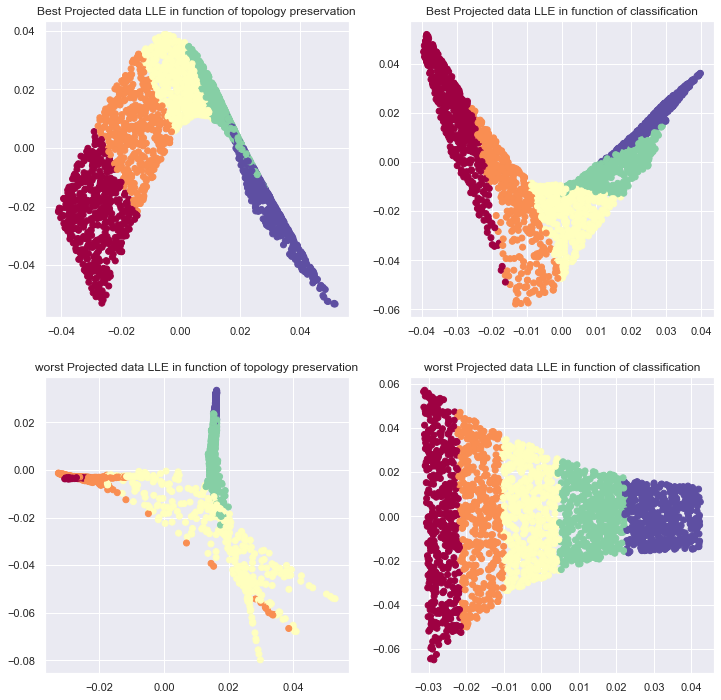

In [311]:
# LLE 

print("Best projection LLE in function of SP")
X_B_LLE_Sp, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=int(Best_Spear_N_LLE),n_components=2)
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_Spear_N_LLE)
print("worst projection LLE ")
X_W_LLE_Sp, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=int(Worst_Spear_N_LLE),n_components=2)
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Worst_Spear_N_LLE)

print("Best projection LLE in function of C")
X_B_LLE_C, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=int(Best_class_N_LLE),n_components=2)
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_class_N_LLE)
print("worst projection LLE ")
X_W_LLE_C, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=int(Worst_class_N_LLE),n_components=2)
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Worst_class_N_LLE)


fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(221)
ax.scatter(X_B_LLE_Sp[:, 0], X_B_LLE_Sp[:, 1], c=color_five, cmap=plt.cm.Spectral)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('Best Projected data LLE in function of topology preservation')

ax = fig.add_subplot(222)
ax.scatter(X_B_LLE_C[:, 0], X_B_LLE_C[:, 1], c=color_five, cmap=plt.cm.Spectral)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('Best Projected data LLE in function of classification')


ax = fig.add_subplot(223)
ax.scatter(X_W_LLE_Sp[:, 0], X_W_LLE_Sp[:, 1], c=color_five, cmap=plt.cm.Spectral)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('worst Projected data LLE in function of topology preservation')
ax = fig.add_subplot(224)
ax.scatter(X_W_LLE_C[:, 0], X_W_LLE_C[:, 1], c=color_five, cmap=plt.cm.Spectral)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('worst Projected data LLE in function of classification')
plt.savefig("LLEClassTopo.png")
plt.show()

Best projection HLLE in function of SP
Done. Reconstruction error: 3.51554e-06
Number of neighbor: 22
worst projection HLLE 
Done. Reconstruction error: 3.27256e-08
Number of neighbor: 7
Best projection HLLE in function of C
Done. Reconstruction error: 3.27256e-08
Number of neighbor: 7
worst projection HLLE 
Done. Reconstruction error: 1.72079e-07
Number of neighbor: 10


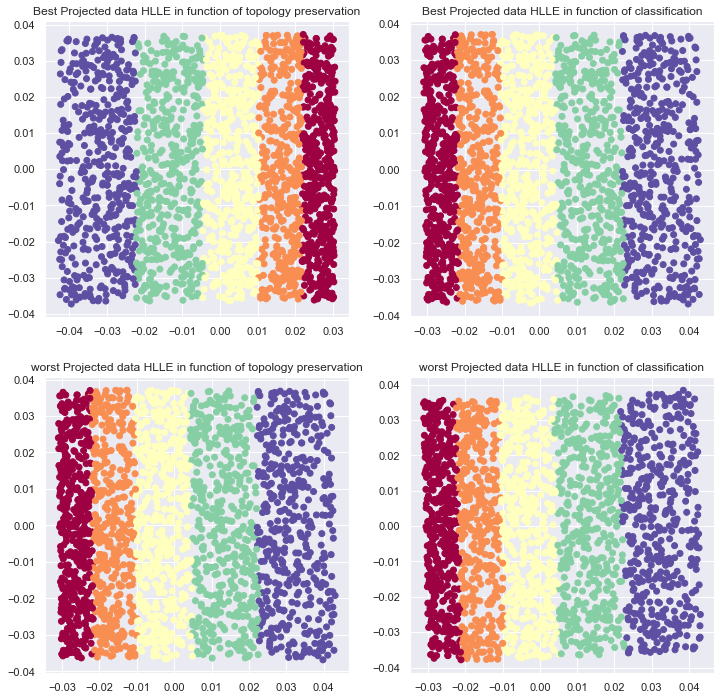

In [312]:
# HLLE 

print("Best projection HLLE in function of SP")
X_B_HLLE_Sp, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=int(Best_Spear_N_HLLE),n_components=2,method = "hessian",eigen_solver="dense")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_Spear_N_HLLE)
print("worst projection HLLE ")
X_W_HLLE_Sp, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=int(Worst_Spear_N_HLLE),n_components=2,method = "hessian",eigen_solver="dense")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Worst_Spear_N_HLLE)

print("Best projection HLLE in function of C")
X_B_HLLE_C, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=int(Best_class_N_HLLE),n_components=2,method = "hessian",eigen_solver="dense")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_class_N_HLLE)
print("worst projection HLLE ")
X_W_HLLE_C, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=int(Worst_class_N_HLLE),n_components=2,method = "hessian",eigen_solver="dense")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Worst_class_N_HLLE)


fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(221)
ax.scatter(X_B_HLLE_Sp[:, 0], X_B_HLLE_Sp[:, 1], c=color_five, cmap=plt.cm.Spectral)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('Best Projected data HLLE in function of topology preservation')

ax = fig.add_subplot(222)
ax.scatter(X_B_HLLE_C[:, 0], X_B_HLLE_C[:, 1], c=color_five, cmap=plt.cm.Spectral)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('Best Projected data HLLE in function of classification')


ax = fig.add_subplot(223)
ax.scatter(X_W_HLLE_Sp[:, 0], X_W_HLLE_Sp[:, 1], c=color_five, cmap=plt.cm.Spectral)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('worst Projected data HLLE in function of topology preservation')
ax = fig.add_subplot(224)
ax.scatter(X_W_HLLE_C[:, 0], X_W_HLLE_C[:, 1], c=color_five, cmap=plt.cm.Spectral)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('worst Projected data HLLE in function of classification')
plt.savefig("HLLEClassTopo.png")
plt.show()

## 3) The effect of the noise

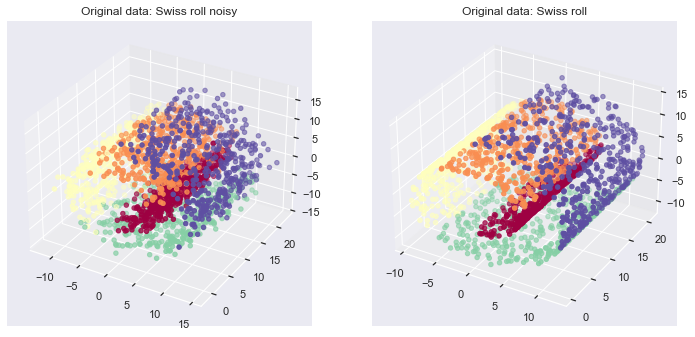

In [345]:
Dataset_swissroll_noisy, color_noisy = datasets.make_swiss_roll(n_samples=2200,noise = 1)
color_five_noisy = []
si = np.size(color_noisy)
vect = np.linspace(min(color_noisy),max(color_noisy),num = 6,endpoint = True,retstep = False, dtype = None)
for i in range(si):
    if color_noisy[i] <= vect[1]:
        color_five_noisy.append(0)
    if color_noisy[i] > vect[1] and color_noisy[i] <= vect[2]:
        color_five_noisy.append(1)
    if color_noisy[i] > vect[2] and color_noisy[i] <= vect[3]:
        color_five_noisy.append(2)
    if color_noisy[i] > vect[3] and color_noisy[i] <= vect[4]:
        color_five_noisy.append(3)
    if color_noisy[i] > vect[4]:
        color_five_noisy.append(4)

Dataset_swissroll, color = datasets.make_swiss_roll(n_samples=2200,noise = 0)
color_five = []
si = np.size(color)
vect = np.linspace(min(color),max(color),num = 6,endpoint = True,retstep = False, dtype = None)
for i in range(si):
    if color[i] <= vect[1]:
        color_five.append(0)
    if color[i] > vect[1] and color[i] <= vect[2]:
        color_five.append(1)
    if color[i] > vect[2] and color[i] <= vect[3]:
        color_five.append(2)
    if color[i] > vect[3] and color[i] <= vect[4]:
        color_five.append(3)
    if color[i] > vect[4]:
        color_five.append(4)
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(Dataset_swissroll_noisy[:, 0], Dataset_swissroll_noisy[:, 1], Dataset_swissroll_noisy[:, 2], c=color_five_noisy, cmap=plt.cm.Spectral)
ax.set_title("Original data: Swiss roll noisy")
ax = fig.add_subplot(122, projection='3d')
ax.scatter(Dataset_swissroll[:, 0], Dataset_swissroll[:, 1], Dataset_swissroll[:, 2], c=color_five, cmap=plt.cm.Spectral)
ax.set_title("Original data: Swiss roll")
plt.savefig("Orignialdatanoisy")


worst K topo = 4 and best K topo = 33
worst K class = 33 and best K class = 5
worst K topo = 8 and best K topo = 29
worst K class = 33 and best K class = 17
worst K topo = 3 and best K topo = 32
worst K class = 33 and best K class = 6
worst K topo = 9 and best K topo = 13
worst K class = 33 and best K class = 9


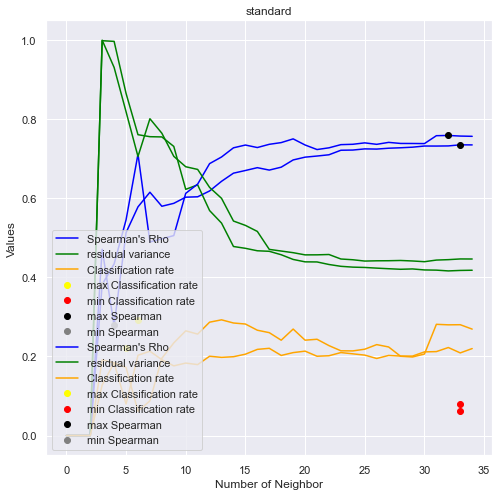

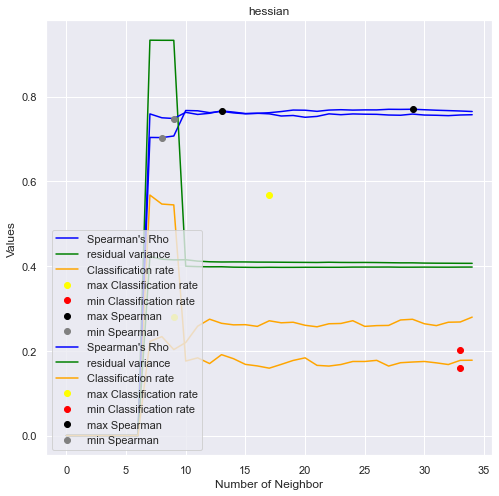

In [346]:
# the swiss roll

Best_N_LLE_noisy,_,_,_ = num_neigh(Dataset_swissroll_noisy,color_five_noisy,2, "standard",50,plot="ON")
Best_N_HLLE_noisy,_,_,_ = num_neigh(Dataset_swissroll_noisy,color_five_noisy,2, "hessian",50,plot="ON")

Best_N_LLE,_,_,_ = num_neigh(Dataset_swissroll,color_five,2, "standard",50,plot="ON")
Best_N_HLLE,_,_,_ = num_neigh(Dataset_swissroll,color_five,2, "hessian",50,plot="ON")
#avec le bruit la hessian marche pas parfois, du coup faut juste reload



Best projection LLE noisy in function of SP
Done. Reconstruction error: 5.1736e-07
Number of neighbor: 33
Best projection HLLE noisy in function of SP
Done. Reconstruction error: 0.0464925
Number of neighbor: 29
Best projection LLE in function of SP
Done. Reconstruction error: 2.87046e-07
Number of neighbor: 32
Best projection HLLE in function of SP
Done. Reconstruction error: 5.66331e-07
Number of neighbor: 13


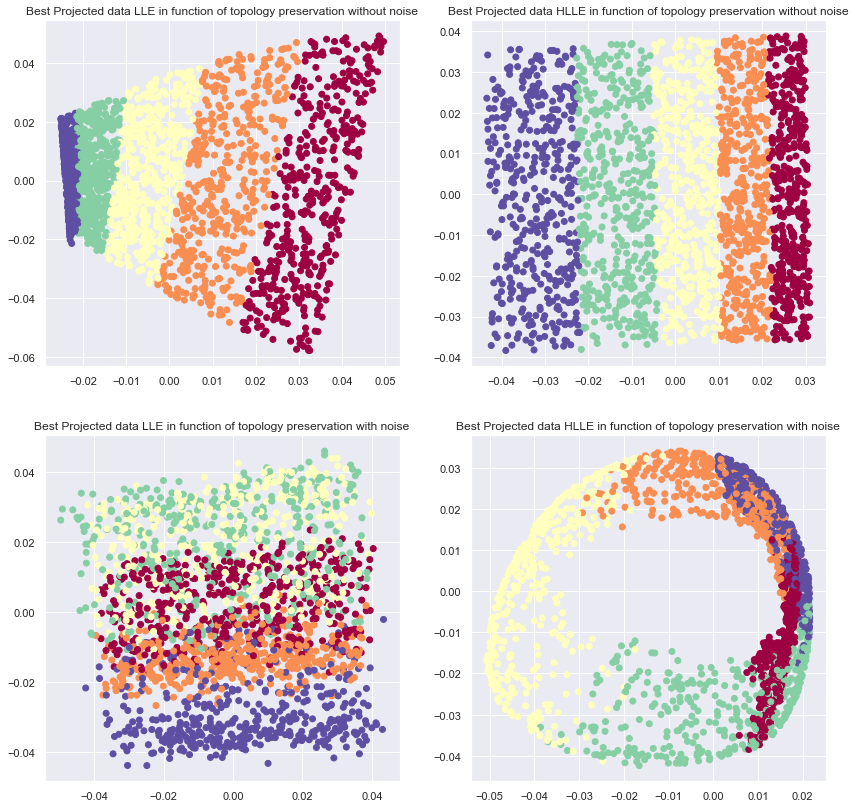

In [347]:
# HLLE  and LLE with or without noise

print("Best projection LLE noisy in function of SP")
X_B_LLE_noisy, err = manifold.locally_linear_embedding(Dataset_swissroll_noisy, n_neighbors=int(Best_N_LLE_noisy),n_components=2,method = "standard",eigen_solver="dense")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_N_LLE_noisy)
print("Best projection HLLE noisy in function of SP")
X_B_HLLE_noisy, err = manifold.locally_linear_embedding(Dataset_swissroll_noisy, n_neighbors=int(Best_N_HLLE_noisy),n_components=2,method = "hessian",eigen_solver="dense")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_N_HLLE_noisy)

print("Best projection LLE in function of SP")
X_B_LLE, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=int(Best_N_LLE),n_components=2,method = "standard",eigen_solver="dense")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_N_LLE)
print("Best projection HLLE in function of SP")
X_B_HLLE, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=int(Best_N_HLLE),n_components=2,method = "hessian",eigen_solver="dense")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_N_HLLE)


fig = plt.figure(figsize=(14, 14))

ax = fig.add_subplot(221)
ax.scatter(X_B_LLE[:, 0], X_B_LLE[:, 1], c=color_five, cmap=plt.cm.Spectral)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('Best Projected data LLE in function of topology preservation without noise')

ax = fig.add_subplot(222)
ax.scatter(X_B_HLLE[:, 0], X_B_HLLE[:, 1], c=color_five, cmap=plt.cm.Spectral)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('Best Projected data HLLE in function of topology preservation without noise')


ax = fig.add_subplot(223)
ax.scatter(X_B_LLE_noisy[:, 0], X_B_LLE_noisy[:, 1], c=color_five_noisy, cmap=plt.cm.Spectral)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('Best Projected data LLE in function of topology preservation with noise')
ax = fig.add_subplot(224)
ax.scatter(X_B_HLLE_noisy[:, 0], X_B_HLLE_noisy[:, 1], c=color_five_noisy, cmap=plt.cm.Spectral)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('Best Projected data HLLE in function of topology preservation with noise')
plt.savefig("ClassToponoisy.png")
plt.show()

In [ ]:
# to do plot with the four best SP


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Original', "LLE" 'HLLE', 'PCA']
students = [Acc,Acc_LLE,Acc_HLLE,Acc_PCA]
ax.bar(langs,students)
plt.title(" Spearman score in function of method")
plt.show()

# SemeionHandwritten Digit Data Set

This dataset consists of 1593 records and 256 attributes.

Each record represents a handwritten digit, orginally scanned with a resolution of 256 grays scale (28).

The image was binarizate with a treshold equal to 127. 
Finally, each binary image was scaled into a 16x16 square box to arrive with 256 binary attributes.

In [41]:
# reading csv files
data =  pd.read_csv('Data/semeion.data',header=None, sep=" ")
data = data.drop(columns=[266])
# 256 first columns is pixel and the last 10 is to say which number is it.
# 1593 data
data.shape
#names = ["zero_slow","zero_fast","one_slow","one_fast","two_slow","two_fast","three_slow","three_fast","four_slow","four_fast","five_slow","five_fast","six_slow","six_fast","seven_slow","seven_fast","eight_slow","eight_fast","nine_slow","nine_fast"]
names = ["zero","one","two","three","four","five","six","seven","eight","nine"]

dataf_labels = data.iloc[0:, 256:].astype(int)
dataf_images = data.iloc[0:, :256]

# put the data label in one dim
dataf_labels_oneD= [0]*1593
for i in range(10):
    for j in range (1593):
        if dataf_labels[i+256][j] == 1:
            dataf_labels_oneD[j] = i

Lab = pd.DataFrame(data = dataf_labels_oneD, columns = ['Label'])

In [42]:
# keep just the pixel for visualization

images = data.truncate(before="0", after="255", axis="columns")
image =[0]*1593
image_reshape =[0]*1593
for i in range (0,1592):
    image[i] = np.array(images.iloc[i])
    image_reshape[i] = np.reshape(image[i],(16,16))

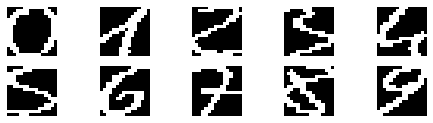

In [63]:
#plot each image
vector_im = [1,21,41,61,81,101,121,141,161,181]
j = 1
fig = plt.figure(figsize=(8, 2))
for i in vector_im:
    ax = fig.add_subplot(2,5,j)
    ax.imshow(image_reshape[i], cmap=plt.cm.gray)  
    ax.axis('off')

    j = j+1
plt.savefig("numero.png")

In [64]:
# Hyperparamters
# K       : number of neighbors
# d       : dimensions reductivity

K    = 22
d    = 2
Kmax = 20



In [313]:
# We split the data into train and test to evaluate the classification 
Split = 0.3
dataf_images_St     = StandardScaler().fit_transform(dataf_images)
dataf_images_Norm   = Normalizer().fit_transform(dataf_images)

# la norm fait buger

#X_train_Norm, X_test_Norm, Label_train_1, Label_test = train_test_split(dataf_images_Norm, Lab, test_size=Split)

X_train, X_test, Label_train, Label_test = train_test_split(dataf_images, Lab, test_size=Split)
# Here we normalize the data (Not neceesary on our case because data is black and white pixel)
X_train_St    = StandardScaler().fit_transform(X_train)
X_test_St     = StandardScaler().fit_transform(X_test)
X_train_Norm  = Normalizer().fit_transform(X_train_St)
X_test_Norm   = Normalizer().fit_transform(X_test_St)


## LLE for visuability

Here we focus our study on the visuability. We define d = 2 and we try to keep the best topology. Thus we use spearman's Rho.

In [193]:
train = X_train.values
test = X_test.values
labeltrain = Label_train.values
labeltest  = Label_test.values


In [314]:
train = X_train_Norm
test = X_test_Norm
labeltrain = Label_train.values
labeltest  = Label_test.values

Acc score is 0.9288702928870293
f1 score for each is [0.99009901 0.92929293 0.93333333 0.90909091 0.92857143 0.92307692
 0.96296296 0.95652174 0.9        0.84536082]
f1 score mean is 0.9278310060102181


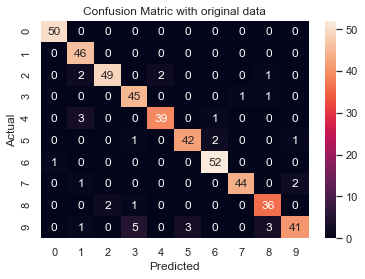

In [354]:

ypred,Acc,Fone = BestPredictKNN(train,test,labeltrain,labeltest, Kmax)

print("Acc score is " + str(Acc))
print("f1 score for each is " + str(Fone))
print("f1 score mean is " + str(np.mean(Fone)))
lab_test = []
for i in range ( np.size(labeltest)):
    lab_test.append(labeltest[i][0])
lab_test =   np.array(lab_test)

data = {'y_Actual':    lab_test,
        'y_Predicted': ypred
        }


df = pd.DataFrame(data, columns=['y_Actual',"y_Predicted"])

confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.title("Confusion Matric with original data")

plt.savefig("ConfMaoriginal.png")


worst K topo = 16 and best K topo = 13
worst K class = 33 and best K class = 8
worst K topo = 16 and best K topo = 13
worst K class = 33 and best K class = 8


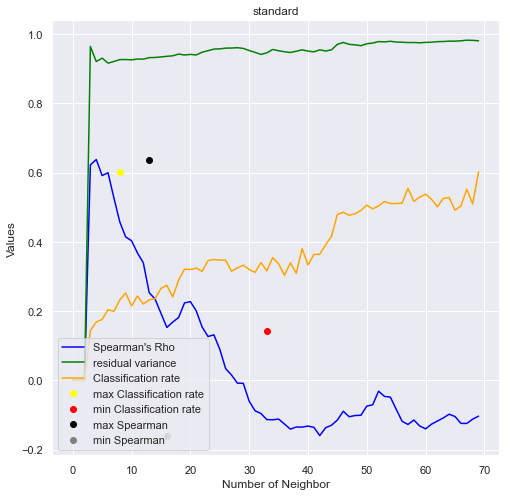

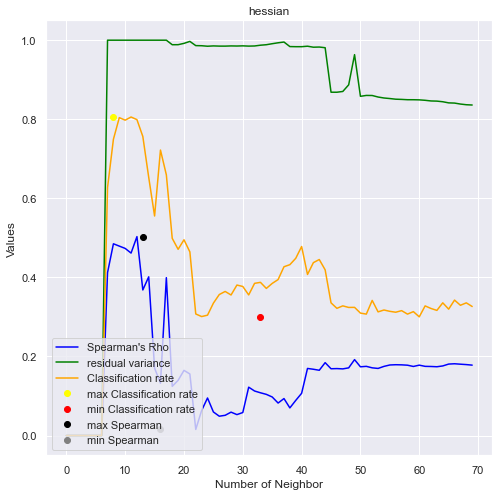

In [316]:

Best_SP_LLE,_,Best_C_LLE,_ = num_neigh_RD(train, test, labeltrain, labeltest,2, "standard",50,plot="ON")
Best_SP_HLLE,_,Best_C_HLLE,_ = num_neigh_RD(train, test, labeltrain, labeltest,2, "hessian",50,plot="ON")


worst K topo = 29 and best K topo = 3
worst K class = 6 and best K class = 32


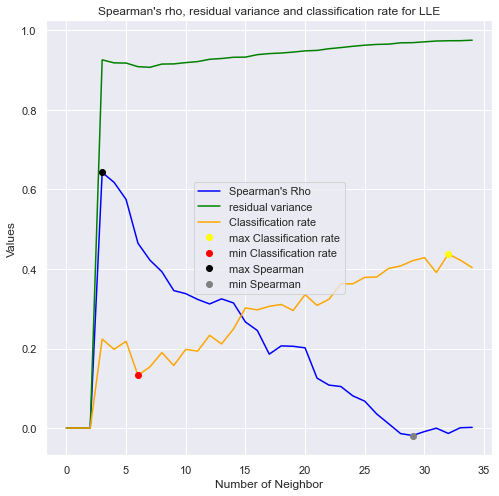

In [288]:
#we use this cell to save the plot in the function

Data =train
Label=labeltrain
dim= 2
meth="standard"
Kmx=50
plot="ON"

SP_Rho_vect       = []
Residual_var_vect = []
classif_vect      = []
N_Neigh_Max       = 35
NCOMP             = 2


# We split the data into train and test to evaluate the classification 
Split = 0.3
X_tr, X_ts, Label_tr, Label_ts = train_test_split(Data, Label, test_size=Split)

# Here we normalize the data (Not neceesary on our case because data is black and white pixel)
X_tr_St     = StandardScaler().fit_transform(X_tr)
X_ts_St     = StandardScaler().fit_transform(X_ts)
X_tr_Norm   = Normalizer().fit_transform(X_tr_St)
X_ts_Norm   = Normalizer().fit_transform(X_ts_St)

if meth == "standard":
    nmin   = NCOMP+1
    Vect_N = np.arange(nmin,N_Neigh_Max,1)
if meth == "hessian":
    nmin   = round(NCOMP*(NCOMP+3)/2)+2
    Vect_N = np.arange( nmin,N_Neigh_Max,1)
Tot_Err     = []
for j in range(nmin):
    SP_Rho_vect.append(0)
    Residual_var_vect.append(0)
    classif_vect.append(0)

for i in Vect_N:
    clf = manifold.LocallyLinearEmbedding(n_neighbors=i,n_components=NCOMP,method = meth,eigen_solver="dense")
    X_tr_transfo  = clf.fit_transform(X_tr_Norm)
    X_ts_transfo  = clf.transform(X_ts_Norm)
    kopt_transfo = knn(X_tr_transfo,X_ts_transfo,Label_tr,Label_ts, Kmx)
    classif_vect.append(classifR(X_tr_Norm,X_ts_Norm,X_tr_transfo,X_ts_transfo,Label_tr,Label_ts,kopt_transfo))
    SP_Rho_vect.append(SpearsmansRho(X_tr_transfo,X_tr_Norm))
    Residual_var_vect.append(res_var(X_tr_transfo,X_tr_Norm))


maxval_C =max(classif_vect[nmin:]) 
indicemax_C = classif_vect.index(maxval_C)
minval_C =min(classif_vect[nmin:]) 
indicemin_C = classif_vect.index(minval_C)

maxval_SP =max(SP_Rho_vect[nmin:]) 
indicemax_SP = SP_Rho_vect.index(maxval_SP)
minval_SP =min(SP_Rho_vect[nmin:]) 
indicemin_SP = SP_Rho_vect.index(minval_SP)

name = "Spearman's rho, residual variance and classification rate for LLE"
if plot == "ON":
    plt.figure(meth,figsize=(8, 8))
    plt.title( name)
    plt.xlabel("Number of Neighbor")
    plt.ylabel("Values")
    plt.plot (SP_Rho_vect,color ="blue",label="Spearman's Rho")
    plt.plot (Residual_var_vect,color ="green",label="residual variance")
    plt.plot(classif_vect,color ="orange",label="Classification rate")

    plt.plot (indicemax_C,maxval_C,"go",color ="yellow",label="max Classification rate")
    plt.plot (indicemin_C,minval_C,"go",color ="red",label="min Classification rate")

    plt.plot (indicemax_SP,maxval_SP,"go",color ="black",label="max Spearman")
    plt.plot (indicemin_SP,minval_SP,"go",color ="grey",label="min Spearman")

    plt.legend()
    print("worst K topo = "+ str(indicemin_SP) +" and best K topo = " + str(indicemax_SP))
    print("worst K class = "+ str(indicemin_C) +" and best K class = " + str(indicemax_C))
    plt.savefig("SpCLLE_RD.png")



worst K topo = 16 and best K topo = 13
worst K class = 33 and best K class = 8


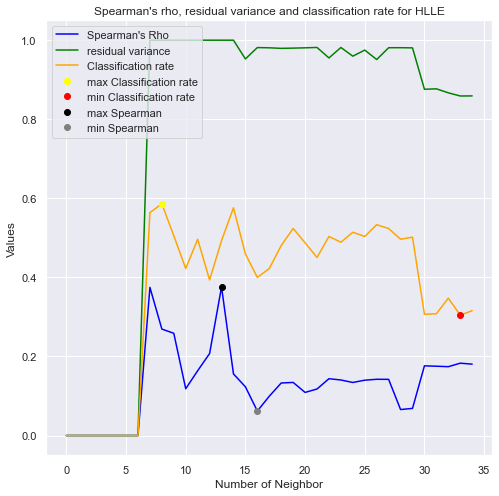

In [289]:
#we use this cell to save the plot in the function

Data =train
Label=labeltrain
dim= 2
meth="hessian"
Kmx=50
plot="ON"

SP_Rho_vect       = []
Residual_var_vect = []
classif_vect      = []
N_Neigh_Max       = 35
NCOMP             = 2


# We split the data into train and test to evaluate the classification 
Split = 0.3
X_tr, X_ts, Label_tr, Label_ts = train_test_split(Data, Label, test_size=Split)

# Here we normalize the data (Not neceesary on our case because data is black and white pixel)
X_tr_St     = StandardScaler().fit_transform(X_tr)
X_ts_St     = StandardScaler().fit_transform(X_ts)
X_tr_Norm   = Normalizer().fit_transform(X_tr_St)
X_ts_Norm   = Normalizer().fit_transform(X_ts_St)

if meth == "standard":
    nmin   = NCOMP+1
    Vect_N = np.arange(nmin,N_Neigh_Max,1)
if meth == "hessian":
    nmin   = round(NCOMP*(NCOMP+3)/2)+2
    Vect_N = np.arange( nmin,N_Neigh_Max,1)
Tot_Err     = []
for j in range(nmin):
    SP_Rho_vect.append(0)
    Residual_var_vect.append(0)
    classif_vect.append(0)

for i in Vect_N:
    clf = manifold.LocallyLinearEmbedding(n_neighbors=i,n_components=NCOMP,method = meth,eigen_solver="dense")
    X_tr_transfo  = clf.fit_transform(X_tr_Norm)
    X_ts_transfo  = clf.transform(X_ts_Norm)
    kopt_transfo = knn(X_tr_transfo,X_ts_transfo,Label_tr,Label_ts, Kmx)
    classif_vect.append(classifR(X_tr_Norm,X_ts_Norm,X_tr_transfo,X_ts_transfo,Label_tr,Label_ts,kopt_transfo))
    SP_Rho_vect.append(SpearsmansRho(X_tr_transfo,X_tr_Norm))
    Residual_var_vect.append(res_var(X_tr_transfo,X_tr_Norm))


maxval_C =max(classif_vect[nmin:]) 
indicemax_C = classif_vect.index(maxval_C)
minval_C =min(classif_vect[nmin:]) 
indicemin_C = classif_vect.index(minval_C)

maxval_SP =max(SP_Rho_vect[nmin:]) 
indicemax_SP = SP_Rho_vect.index(maxval_SP)
minval_SP =min(SP_Rho_vect[nmin:]) 
indicemin_SP = SP_Rho_vect.index(minval_SP)

name = "Spearman's rho, residual variance and classification rate for HLLE"
if plot == "ON":
    plt.figure(meth,figsize=(8, 8))
    plt.title( name)
    plt.xlabel("Number of Neighbor")
    plt.ylabel("Values")
    plt.plot (SP_Rho_vect,color ="blue",label="Spearman's Rho")
    plt.plot (Residual_var_vect,color ="green",label="residual variance")
    plt.plot(classif_vect,color ="orange",label="Classification rate")

    plt.plot (indicemax_C,maxval_C,"go",color ="yellow",label="max Classification rate")
    plt.plot (indicemin_C,minval_C,"go",color ="red",label="min Classification rate")

    plt.plot (indicemax_SP,maxval_SP,"go",color ="black",label="max Spearman")
    plt.plot (indicemin_SP,minval_SP,"go",color ="grey",label="min Spearman")

    plt.legend()
    print("worst K topo = "+ str(indicemin_SP) +" and best K topo = " + str(indicemax_SP))
    print("worst K class = "+ str(indicemin_C) +" and best K class = " + str(indicemax_C))
    plt.savefig("SpCHLLE_RD.png")



In [317]:

X_RD_LLE_Sp, err = manifold.locally_linear_embedding(train, n_neighbors=int(Best_SP_LLE),n_components=2,method = "standard",eigen_solver="dense")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_SP_LLE)
print("worst projection HLLE ")
X_RD_HLLE_Sp, err = manifold.locally_linear_embedding(train, n_neighbors=int(Best_SP_HLLE),n_components=2,method = "hessian",eigen_solver="dense")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_SP_HLLE)

print("Best projection HLLE in function of C")
X_RD_LLE_C, err = manifold.locally_linear_embedding(train, n_neighbors=int(Best_C_LLE),n_components=2,method = "standard",eigen_solver="dense")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_C_LLE)
print("worst projection HLLE ")
X_RD_HLLE_C, err = manifold.locally_linear_embedding(train, n_neighbors=int(Best_C_HLLE),n_components=2,method = "hessian",eigen_solver="dense")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_C_HLLE)



Done. Reconstruction error: 8.64148e-09
Number of neighbor: 4
worst projection HLLE 
Done. Reconstruction error: -1.3585e-16
Number of neighbor: 12
Best projection HLLE in function of C
Done. Reconstruction error: 1.36948e-16
Number of neighbor: 3
worst projection HLLE 
Done. Reconstruction error: 11.26
Number of neighbor: 60


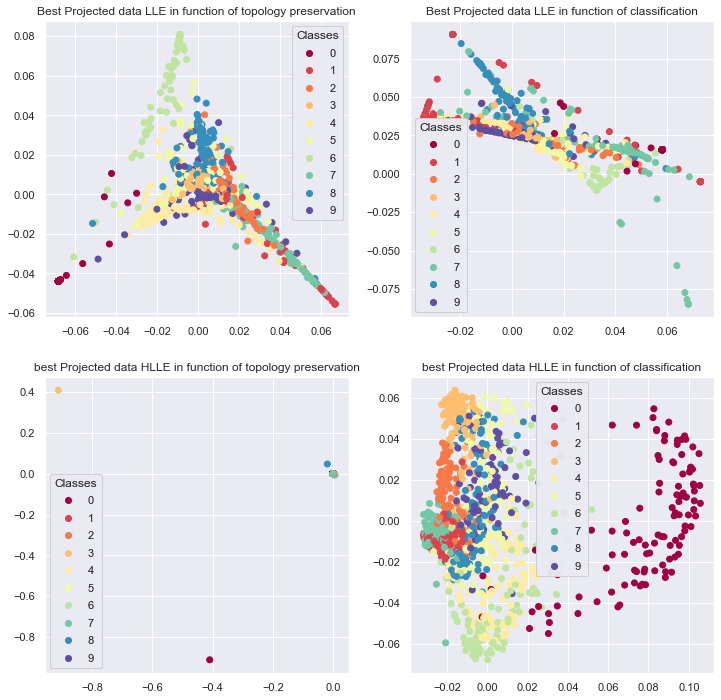

In [318]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(221)
scatter = ax.scatter(X_RD_LLE_Sp[:, 0], X_RD_LLE_Sp[:, 1], c=labeltrain, cmap=plt.cm.Spectral)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('Best Projected data LLE in function of topology preservation')

ax = fig.add_subplot(222)
scatter = ax.scatter(X_RD_LLE_C[:, 0], X_RD_LLE_C[:, 1], c=labeltrain, cmap=plt.cm.Spectral)
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('Best Projected data LLE in function of classification')


ax = fig.add_subplot(223)
scatter = ax.scatter(X_RD_HLLE_Sp[:, 0], X_RD_HLLE_Sp[:, 1], c=labeltrain, cmap=plt.cm.Spectral)
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('best Projected data HLLE in function of topology preservation')
ax = fig.add_subplot(224)
scatter = ax.scatter(X_RD_HLLE_C[:, 0], X_RD_HLLE_C[:, 1], c=labeltrain, cmap=plt.cm.Spectral)
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('best Projected data HLLE in function of classification')
plt.savefig("HLLEClassTopo_RD.png")
plt.show()




Acc score is 0.9288702928870293
f1 score for each is [0.97029703 0.68888889 0.59504132 0.7037037  0.83333333 0.57471264
 0.93333333 0.70588235 0.60465116 0.56179775]
f1 score mean is 0.7171641523495302


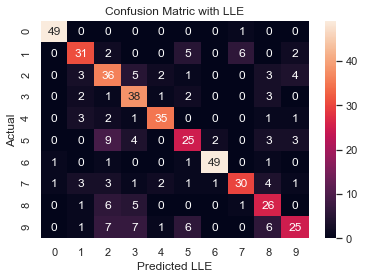

In [355]:
clf_LLE = manifold.LocallyLinearEmbedding(n_neighbors=Best_C_LLE, n_components=2, method ='standard',eigen_solver="dense")

X_train_LLE = clf_LLE.fit_transform(train)
X_test_LLE  = clf_LLE.transform(test)

ypred_LLE,Acc_LLE, Fone_LLE= BestPredictKNN(X_train_LLE,X_test_LLE,labeltrain,labeltest, Kmax)

print("Acc score is " + str(Acc_LLE))
print("f1 score for each is " + str(Fone_LLE))
print("f1 score mean is " + str(np.mean(Fone_LLE)))
lab_test = []
for i in range ( np.size(labeltest)):
    lab_test.append(labeltest[i][0])
lab_test =   np.array(lab_test)

data = {'y_Actual':    lab_test,
        'y_Predicted_LLE': ypred_LLE
        }


df_LLE = pd.DataFrame(data, columns=['y_Actual',"y_Predicted_LLE"])

confusion_matrix_LLE = pd.crosstab(df_LLE['y_Actual'], df_LLE['y_Predicted_LLE'], rownames=['Actual'], colnames=['Predicted LLE'])

sn.heatmap(confusion_matrix_LLE, annot=True)
plt.title("Confusion Matric with LLE")

plt.savefig("ConfMaLLE.png")


Acc score is 0.5962343096234309
f1 score for each is [0.9375     0.57627119 0.72727273 0.7032967  0.50485437 0.52873563
 0.38356164 0.71111111 0.35714286 0.46153846]
f1 score mean is 0.5891284691754101


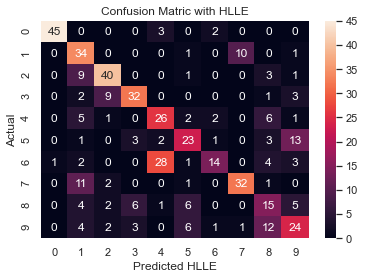

In [356]:
clf_HLLE = manifold.LocallyLinearEmbedding(n_neighbors=Best_C_HLLE, n_components=2, method ='hessian',eigen_solver="dense")

X_train_HLLE = clf_HLLE.fit_transform(train)
X_test_HLLE  = clf_HLLE.transform(test)


ypred_HLLE,Acc_HLLE,Fone_HLLE = BestPredictKNN(X_train_HLLE,X_test_HLLE,labeltrain,labeltest, Kmax)
print("Acc score is " + str(Acc_HLLE))
print("f1 score for each is " + str(Fone_HLLE))
print("f1 score mean is " + str(np.mean(Fone_HLLE)))
lab_test = []
for i in range ( np.size(labeltest)):
    lab_test.append(labeltest[i][0])
lab_test =   np.array(lab_test)

data = {'y_Actual':    lab_test,
        'y_Predicted_HLLE': ypred_HLLE
        }


df_HLLE = pd.DataFrame(data, columns=['y_Actual',"y_Predicted_HLLE"])

confusion_matrix_HLLE = pd.crosstab(df_HLLE['y_Actual'], df_HLLE['y_Predicted_HLLE'], rownames=['Actual'], colnames=['Predicted HLLE'])

sn.heatmap(confusion_matrix_HLLE, annot=True)
plt.title("Confusion Matric with HLLE")

plt.savefig("ConfMaHLLE.png")


[0.07581974 0.06576868]
[9.19428433 8.56320519]


Text(0.5, 1.0, 'Best Projected data pca')

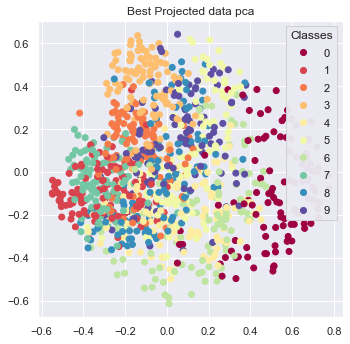

In [322]:
# pca 
pca = PCA(n_components=2)
X_train_PCA =pca.fit_transform(train)
X_test_PCA  = pca.transform(test)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

principalDf = pd.DataFrame(data = X_train_PCA, columns = ['PrComp 1', 'PrComp 2',]) 
LAB = pd.DataFrame(data = labeltrain, columns = ['Label']) 

pca_Df = pd.concat([principalDf, LAB], axis = 1)

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(221)
scatter = ax.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1], c=labeltrain, cmap=plt.cm.Spectral)
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
#plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('Best Projected data pca')


Acc score is 0.4686192468619247
f1 score for each is [0.87128713 0.40366972 0.41509434 0.63829787 0.34       0.46728972
 0.46153846 0.5045045  0.25       0.18461538]
f1 score mean is 0.45362971357310994


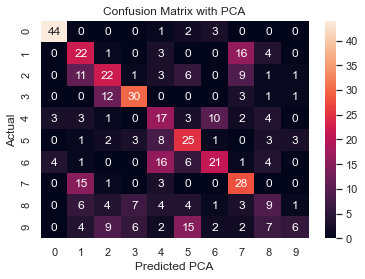

In [359]:
ypred_PCA, Acc_PCA,Fone_PCA= BestPredictKNN(X_train_PCA,X_test_PCA,labeltrain,labeltest, Kmax)
print("Acc score is " + str(Acc_PCA))
print("f1 score for each is " + str(Fone_PCA))
print("f1 score mean is " + str(np.mean(Fone_PCA)))
lab_test = []
for i in range ( np.size(labeltest)):
    lab_test.append(labeltest[i][0])
lab_test =   np.array(lab_test)

data = {'y_Actual':    lab_test,
        'y_Predicted pca': ypred_PCA
        }


df_PCA = pd.DataFrame(data, columns=['y_Actual',"y_Predicted pca"])

confusion_matrix_PCA = pd.crosstab(df_PCA['y_Actual'], df_PCA['y_Predicted pca'], rownames=['Actual'], colnames=['Predicted PCA'])

sn.heatmap(confusion_matrix_PCA, annot=True)
plt.title("Confusion Matrix with PCA")
plt.savefig("Conf_PCA.png")


ValueError: shape mismatch: objects cannot be broadcast to a single shape

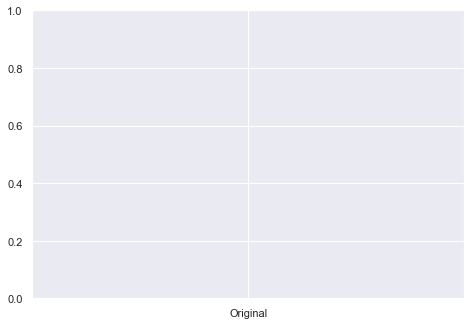

In [362]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Original', "LLE" 'HLLE', 'PCA']
students = [Acc,Acc_LLE,Acc_HLLE,Acc_PCA]
ax.bar(langs,students)
plt.title(" Accuracy score in function of method")
plt.show()

Here we will comput the see the effect of LLE and HLLE in function of the dimensionnality reduction.
Thus ,for each dim, we will find the best number of neighborr in function to have the best classification rate, and his classification rate and spearmans'rho.

done for1
done for2
done for3
done for4
done for5
done for6
done for7
done for8
done for9
done for10


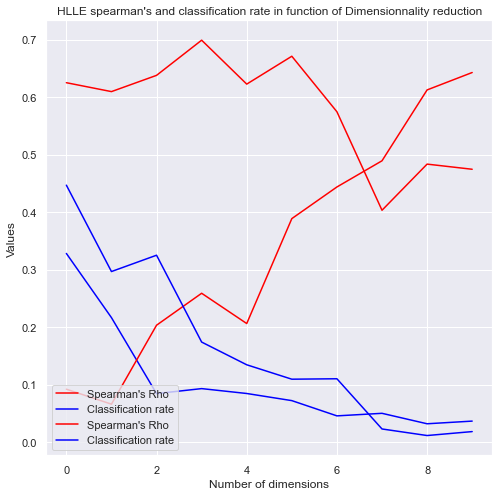

In [358]:
#find the best dim for reduction for LLE
dmax = 10
spearm_LLE = []
classif_LLE = []
spearm_HLLE = []
classif_HLLE = []

for d in np.arange(1,dmax+1,1):

    # find best number of neighbor

    Best_SP_LLE_d,_,Best_C_LLE_d,_ = num_neigh_RD(train, test, labeltrain, labeltest,d, "standard",20,plot="Off")
    Best_SP_HLLE_d,_,Best_C_HLLE_d,_ = num_neigh_RD(train, test, labeltrain, labeltest,d, "hessian",20,plot="Off")

    #compute HLLE with best number of neighbor
    clf_LLE_d = manifold.LocallyLinearEmbedding(n_neighbors=Best_C_LLE_d, n_components=d, method ='standard',eigen_solver="dense")
    clf_HLLE_d = manifold.LocallyLinearEmbedding(n_neighbors=Best_C_HLLE_d, n_components=d, method ='hessian',eigen_solver="dense")

    X_train_LLE_d = clf_LLE_d.fit_transform(train)
    X_test_LLE_d  = clf_LLE_d.transform(test)
    X_train_HLLE_d = clf_HLLE_d.fit_transform(train)
    X_test_HLLE_d  = clf_HLLE_d.transform(test)
    # value for classification rate
    kopt_LLE_d = knn(X_train_LLE_d,X_test_LLE_d,labeltrain,labeltest, Kmax)
    r_LLE_d = classifR(train,test,X_train_LLE_d,X_test_LLE_d,labeltrain,labeltest,kopt_LLE_d)
    classif_LLE.append(r_LLE_d)
    kopt_HLLE_d = knn(X_train_HLLE_d,X_test_HLLE_d,labeltrain,labeltest, Kmax)
    r_HLLE_d = classifR(train,test,X_train_HLLE_d,X_test_HLLE_d,labeltrain,labeltest,kopt_HLLE_d)
    classif_HLLE.append(r_HLLE_d)

    # spearman rho
    spearm_LLE.append(SpearsmansRho(train,X_train_LLE_d))
    spearm_HLLE.append(SpearsmansRho(train,X_train_HLLE_d))
    print("done for" + str(d) )

plt.figure("standard",figsize=(8, 8))
plt.title( "LLE spearman's and classification rate in function of Dimensionnality reduction")
plt.xlabel("Number of dimensions")
plt.ylabel("Values")
plt.plot (spearm_LLE,color ="red",label="Spearman's Rho")
plt.plot (classif_LLE,color ="blue",label="Classification rate")


plt.legend(loc ="lower left")

plt.figure("standard",figsize=(8, 8))
plt.title( "HLLE spearman's and classification rate in function of Dimensionnality reduction")
plt.xlabel("Number of dimensions")
plt.ylabel("Values")
plt.plot (spearm_HLLE,color ="red",label="Spearman's Rho")
plt.plot (classif_HLLE,color ="blue",label="Classification rate")


plt.legend(loc ="lower left")


In [360]:
maxval_SP_LLE  = max(spearm_LLE) 
BD_SP_LLE     = spearm_LLE.index(maxval_SP_LLE)
maxval_SP_HLLE = max(spearm_HLLE) 
BD_SP_HLLE    = spearm_HLLE.index(maxval_SP_HLLE)

minval_C_LLE =min(classif_LLE) 
BD_C_LLE = classif_LLE.index(minval_C_LLE)+1
minval_C_HLLE =min(classif_HLLE) 
BD_C_HLLE = classif_HLLE.index(minval_C_HLLE)+1

print(BD_SP_LLE)
print(BD_SP_HLLE)
print(BD_C_LLE)
print(BD_C_HLLE)

3
9
9
9


worst K topo = 54 and best K topo = 10
worst K class = 65 and best K class = 10
worst K topo = 56 and best K topo = 69
worst K class = 65 and best K class = 69
Done. Reconstruction error: 0.000673824
Number of neighbor: 4
worst projection HLLE 
Done. Reconstruction error: 34.8689
Number of neighbor: 12
Best projection HLLE in function of C
Done. Reconstruction error: 0.0200132
Number of neighbor: 3
worst projection HLLE 
Done. Reconstruction error: 34.8689
Number of neighbor: 60


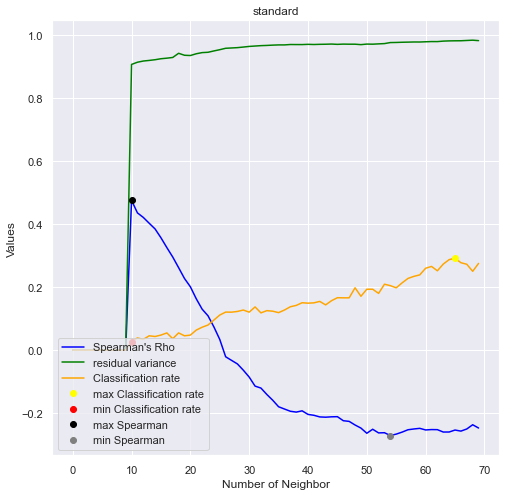

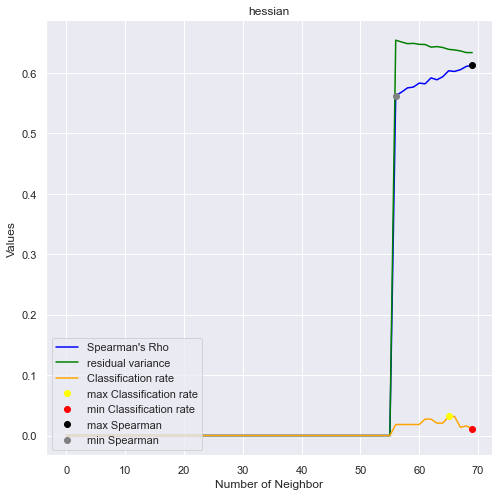

In [364]:

Best_SP_LLE_d,_,Best_C_LLE_d,_ = num_neigh_RD(train, test, labeltrain, labeltest,BD_C_LLE, "standard",50,plot="ON")
Best_SP_HLLE_d,_,Best_C_HLLE_d,_ = num_neigh_RD(train, test, labeltrain, labeltest,BD_C_HLLE, "hessian",50,plot="ON")

X_RD_LLE_Sp, err = manifold.locally_linear_embedding(train, n_neighbors=int(Best_SP_LLE_d),n_components=BD_SP_LLE,method = "standard",eigen_solver="dense")
clf_HLLE = manifold.LocallyLinearEmbedding(n_neighbors=Best_C_HLLE, n_components=Best_SP_LLE_d, method ='hessian',eigen_solver="dense")

X_RD_LLE_Sp    = clf_HLLE.fit_transform(train)
X_RD_LLE_Sp_Ts  = clf_HLLE.transform(test)


X_RD_HLLE_Sp, err = manifold.locally_linear_embedding(train, n_neighbors=int(Best_SP_HLLE_d),n_components=BD_SP_HLLE,method = "hessian",eigen_solver="dense")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_SP_HLLE)

print("Best projection HLLE in function of C")
X_RD_LLE_C, err = manifold.locally_linear_embedding(train, n_neighbors=int(Best_C_LLE_d),n_components=BD_C_LLE,method = "standard",eigen_solver="dense")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_C_LLE)
print("worst projection HLLE ")
X_RD_HLLE_C, err = manifold.locally_linear_embedding(train, n_neighbors=int(Best_C_HLLE_d),n_components=BD_C_HLLE,method = "hessian",eigen_solver="dense")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_C_HLLE)




In [ ]:

ypred = BestPredictKNN(X_train_PCA,X_test_PCA,labeltrain,labeltest, Kmax)
lab_test = []
for i in range ( np.size(labeltest)):
    lab_test.append(labeltest[i][0])
lab_test =   np.array(lab_test)

data = {'y_Actual':    lab_test,
        'y_Predicted': ypred
        }


df = pd.DataFrame(data, columns=['y_Actual',"y_Predicted"])

confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()